In [65]:
library(tidyverse)
library(limma)
library(data.table)

# Load data

In [66]:
preprocess_mxout <- function(path, center_metadata, center){
    PG_report <- read.table(
        path,
        header=T,
        sep="\t",
        stringsAsFactors = F)
    
    # remove decoy matches and matches to contaminant
    PG_report <- PG_report[!PG_report$Reverse=="+",]
    PG_report <- PG_report[!PG_report$Potential.contaminant=="+",]
    # if the PG_report$Only.identified.by.site is not all NA and contains "+" values - remove this rows
    if(!all(is.na(PG_report$Only.identified.by.site))) {
        # # Only.identified.by.site - exclude proteins that were only identified by a modification site
        PG_report <- PG_report[!PG_report$Only.identified.by.site=="+",]
    }

    print(center)
    # take only the columns that we need
    pg_intensities <- PG_report %>%
        select(c("Protein.IDs", "Gene.names", rownames(center_metadata)))

    print(length(pg_intensities$Protein.IDs))

    # counts
    pg_counts <- PG_report %>%
        select(c("Protein.IDs", "Razor...unique.peptides")) 
    rownames(pg_counts) <- pg_counts$Protein.IDs
    pg_counts$Protein.IDs <- NULL
    pg_counts <- pg_counts + 1
    return(list(pg_intensities, pg_counts))    
}

In [67]:
metadata <- read.table("/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/Metadata_CosyBio.tsv",
                       header = TRUE, sep = "\t", stringsAsFactors = FALSE)
                       
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub(" ", ".", Quantitative.column.name))

rownames(metadata) <- metadata$Quantitative.column.name
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub(".Pool", ".P_", gsub("Reporter.intensity.corrected.", "RIC_", Quantitative.column.name)))


# remove the outlier
metadata <- metadata %>%
            filter(Quantitative.column.name != "RIC_3.P_3")


# rename the columns - put the .P_[1-9]+ after dot before and the rest after (e.g. RIC_1.P_1 -> P_1.RIC_1)
metadata <- metadata %>%
            mutate(Quantitative.column.name = gsub("RIC_([0-9]+).P_([0-9]+)", "P_\\2.RIC_\\1", Quantitative.column.name))


head(metadata, 3)
dim(metadata)

,Quantitative.column.name,Pool,Reporter.ion,Patient,Group,Center
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Reporter.intensity.corrected.1.Pool1,P_1.RIC_1,Pool1,126,Common Reference,Common Reference,Center1
Reporter.intensity.corrected.2.Pool1,P_1.RIC_2,Pool1,127N,heathy1,heathy,Center1
Reporter.intensity.corrected.3.Pool1,P_1.RIC_3,Pool1,127C,FSGS1,FSGS,Center1


[1] 65  6

In [68]:
list_of_outputs <- list(
    "Center1" = "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/proteinGroups_center1.txt",
    "Center2" = "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/proteinGroups_center2.txt",
    "Center3" = "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/raw_MaxQuant_reports/proteinGroups_center3.txt"
)

combined_pg_intensities <- data.frame()

for(center in names(list_of_outputs)) {

    center_metadata <- metadata %>%
        filter(Center == center)

    results_list <- preprocess_mxout(list_of_outputs[[center]], center_metadata, center)
    pg_intensities <- results_list[[1]]
    counts_df <- results_list[[2]]

    pg_intensities <- pg_intensities[, c("Protein.IDs", "Gene.names", rownames(center_metadata))]
    colnames(pg_intensities) <- c("Protein.IDs", "Gene.names", center_metadata$Quantitative.column.name)
    
    if(!(nrow(combined_pg_intensities) == 0)) {
        combined_pg_intensities <- inner_join(combined_pg_intensities, pg_intensities, by = c("Protein.IDs", "Gene.names"))
    } else {
        combined_pg_intensities <- pg_intensities
    }
}

combined_pg_intensities <- combined_pg_intensities[, c("Protein.IDs", "Gene.names", metadata$Quantitative.column.name)]
cat('Result:', dim(combined_pg_intensities), '\n')

rownames(metadata) <- metadata$Quantitative.column.name
metadata <- metadata %>%
    mutate(Quantitative.column.name = gsub(" ", ".", Quantitative.column.name))


[1] "Center1"
[1] 500
[1] "Center2"
[1] 530
[1] "Center3"
[1] 456
Result: 228 67 


In [69]:
head(metadata)

,Quantitative.column.name,Pool,Reporter.ion,Patient,Group,Center
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
P_1.RIC_1,P_1.RIC_1,Pool1,126,Common Reference,Common Reference,Center1
P_1.RIC_2,P_1.RIC_2,Pool1,127N,heathy1,heathy,Center1
P_1.RIC_3,P_1.RIC_3,Pool1,127C,FSGS1,FSGS,Center1
P_1.RIC_4,P_1.RIC_4,Pool1,128N,heathy2,heathy,Center1
P_1.RIC_5,P_1.RIC_5,Pool1,128C,FSGS2,FSGS,Center1
P_1.RIC_6,P_1.RIC_6,Pool1,129N,heathy3,heathy,Center1


In [70]:
meta_data <- metadata %>% as.data.table()
prot_data <- combined_pg_intensities %>% as.data.table()


In [71]:
# Replace all 0s with NAs in specified columns of prot_data
prot_data[, (meta_data$Quantitative.column.name) := lapply(.SD, function(x) { ifelse(x == 0, NA, x) }), .SDcols = meta_data$Quantitative.column.name]

In [72]:
filter_na_proteins <- function(dt, meta_data) {
    # Filter out proteins that have NAs in all columns
    dt <- dt[!rowSums(is.na(dt[, (meta_data$Quantitative.column.name), with = FALSE])) == length(meta_data$Quantitative.column.name)]
    return(dt)
}

cat('Before filtering:', dim(prot_data), '\n')
prot_data <- filter_na_proteins(prot_data, meta_data)
cat('After filtering:', dim(prot_data), '\n')

Before filtering: 228 67 
After filtering: 228 67 


# plots

In [73]:
pca_plot <- function(df, batch_info, title, path, quantitative_col_name = "Quantitative.column.name", col_col = "Group", shape_col = "Center") {
  pca <- prcomp(t(na.omit(df)))
  pca_df <- pca$x %>%
    as.data.frame() %>%
    rownames_to_column(quantitative_col_name) %>% 
    left_join(batch_info, by = quantitative_col_name)
  var_expl <- pca$sdev^2 / sum(pca$sdev^2)
  names(var_expl) <- paste0("PC", 1:length(var_expl))

  pca_plot <- pca_df %>%
    ggplot(aes_string(x = "PC1", y = "PC2", color = col_col, shape = shape_col)) + # Note: aes_string is deprecated, consider using aes() with !!sym() for newer versions
    geom_point(size=3) +
    theme_classic() +
    labs(title = title,
         x = glue::glue("PC1 [{round(var_expl['PC1']*100, 2)}%]"),
         y = glue::glue("PC2 [{round(var_expl['PC2']*100, 2)}%]"))

  if (path == "") {
    return(pca_plot)
  } else {
    ggsave(path, pca_plot, width = 5, height = 5)
    return(pca_plot)
  }
}


# boxplot
boxplot_pg <- function(protein_matrix, title, path) {
  # Reshape data into long format
  long_data <- tidyr::gather(protein_matrix, 
                             key = "file", value = "Intensity")
  # Log tranformed scale
  boxplot <- ggplot(long_data, aes(x = file, y = Intensity)) + 
    geom_boxplot() +
    stat_summary(fun = mean, geom = "point", shape = 4, size = 3, color = "red") +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
    # adjust fonsize for the x-axis
    theme(axis.text.x = element_text(size = 8)) +
    labs(title = title) 

  if(path == "") {
    return(boxplot)
  } else {
      ggsave(path, boxplot)
      return(boxplot)
  }

}



In [74]:
# set size of the plots
options(repr.plot.width=6, repr.plot.height=5)

# before

Warning message:
“Removed 425 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 425 rows containing non-finite values (`stat_summary()`).”


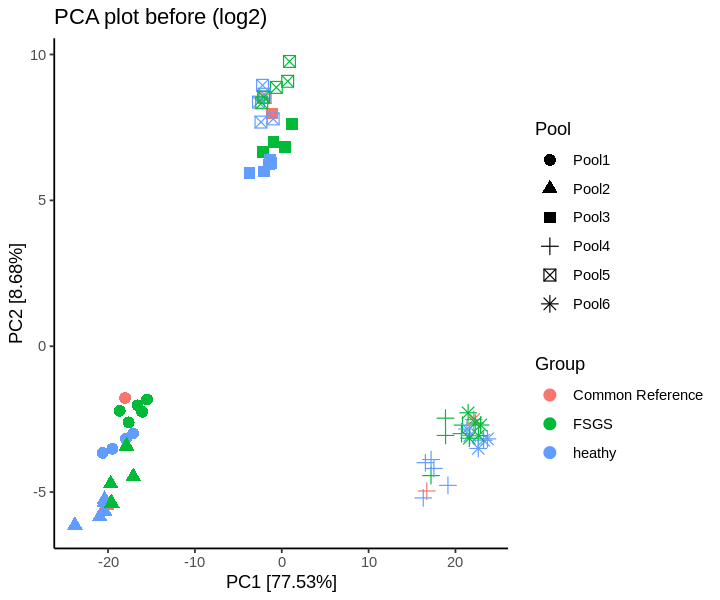

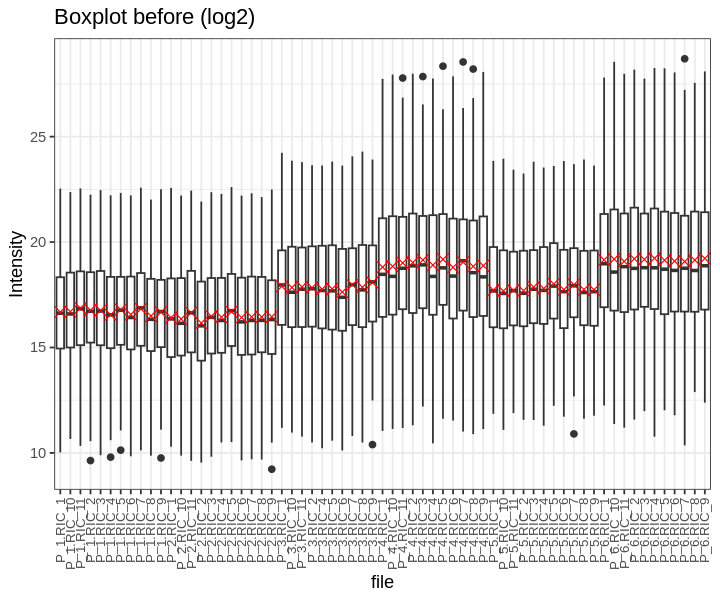

In [75]:
# plot PCA
pca_plot(log2(prot_data[, -c("Protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot before (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")
pca_before <- pca_plot(log2(prot_data[, -c("Protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot before (log2)", "",
            "Quantitative.column.name", col_col = "Group", shape_col = "Pool")

# plot boxplot
boxplot_pg(log2(prot_data[, -c("Protein.IDs", "Gene.names")]+1), "Boxplot before (log2)", "")
boxplot_before <- boxplot_pg(log2(prot_data[, -c("Protein.IDs", "Gene.names")]+1), "Boxplot before (log2)", "")

# Median norm

In [84]:
# ffrom PRONE.R

medianNorm <- function(dt, metadata){
  # find median of each sample
  sample_med <- apply(dt, 2, stats::median, na.rm=TRUE) # columns
  # find mean of medians
  mean_med <- mean(sample_med, na.rm=TRUE)
  # divide data by median
  norm_dt <- t(t(dt)/sample_med)
  # multiply data by mean of medians
  norm_dt <- norm_dt * mean_med
  norm_dt <- data.table::as.data.table(norm_dt)
  colnames(norm_dt) <- colnames(dt)
  rownames(norm_dt) <- rownames(dt)
  return(norm_dt)
}

Warning message:
“Removed 425 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 425 rows containing non-finite values (`stat_summary()`).”


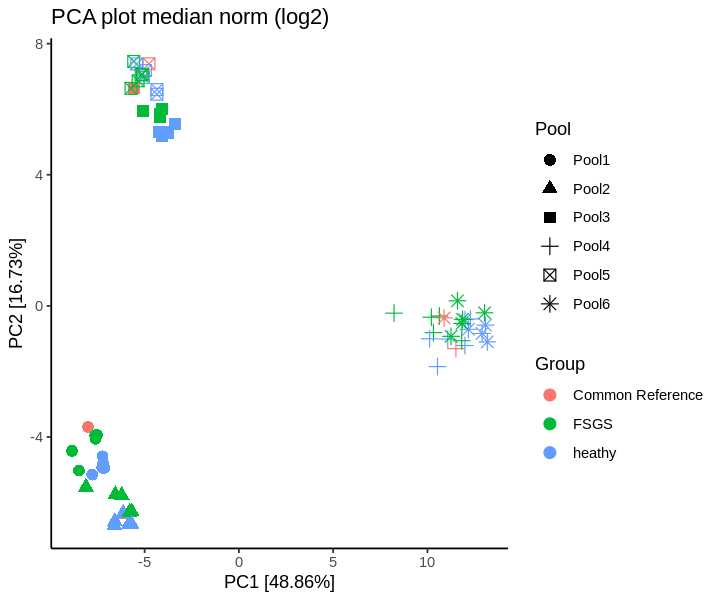

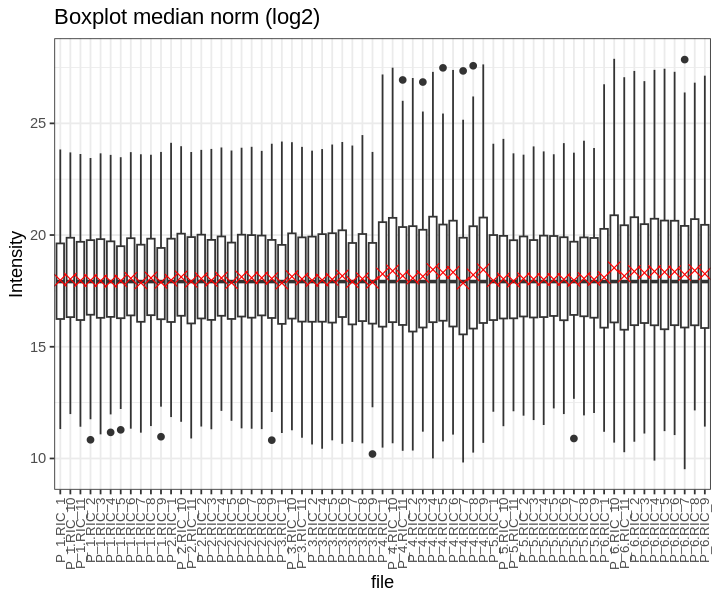

In [97]:
median <- medianNorm(prot_data[, -c("Protein.IDs", "Gene.names")], meta_data)
# add back the Protein.IDs and Gene.names
median <- cbind(prot_data[, c("Protein.IDs", "Gene.names")], median)

# plot PCA
pca_plot(log2(median[, -c("Protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot median norm (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")
pca_median <- pca_plot(log2(median[, -c("Protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot median norm (log2)", "",
            "Quantitative.column.name", col_col = "Group", shape_col = "Pool")


# plot boxplot
boxplot_pg(log2(median[, -c("Protein.IDs", "Gene.names")]+1), "Boxplot median norm (log2)", "")
boxplot_median <- boxplot_pg(log2(median[, -c("Protein.IDs", "Gene.names")]+1), "Boxplot median norm (log2)", "")

# IRS

In [117]:
irsNorm <- function(dt, md, batch, refs){
  # get md of reference samples
  refs_md <- md[md$Quantitative.column.name %in% refs,]
# separate data by batch
  dt_list <- lapply(unique(md[["Pool"]]), function(b){
      md_chunk <- md[md[["Pool"]] == b,]
      dt_chunk <- subset(dt, select = md_chunk$Quantitative.column.name)
      return(dt_chunk)
  })
  names(dt_list) <- unique(md[["Pool"]])
  
  # take reference sample intensities
  irs <- subset(dt, select = refs_md$Quantitative.column.name)
  colnames(irs) <- as.character(refs_md[refs_md$Quantitative.column.name %in% refs,][["Pool"]])
  
  # get the geometric average intensity for each protein
  irs <- tibble::as_tibble(irs)
  irs$average <- apply(irs, 1, function(x) exp(mean(log(x), na.rm=TRUE)))
  # normalize data
  dt_irs_list <- lapply(names(dt_list), function(b){
    # compute scaling factor vectors
    fac <- irs$average / irs[,b]
    # normalize
    dt_irs_chunk <- dt_list[[b]] * fac[,1]
    return(dt_irs_chunk)
  })
  # reconstruct data after irs normalization
  dt_irs <- do.call(cbind, dt_irs_list)
  dt_irs <- data.table::as.data.table(dt_irs)
  dt_irs <- subset(dt_irs, select = colnames(dt))
  
  return(dt_irs)
}

Warning message:
“Removed 429 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 429 rows containing non-finite values (`stat_summary()`).”


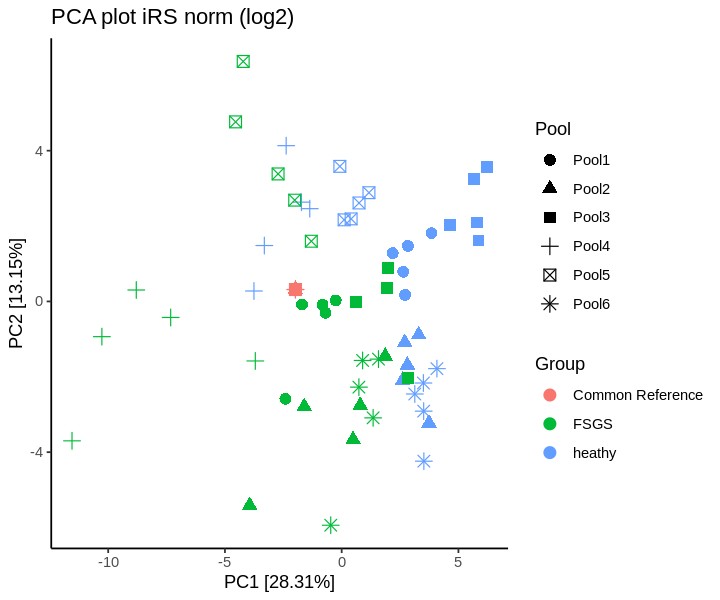

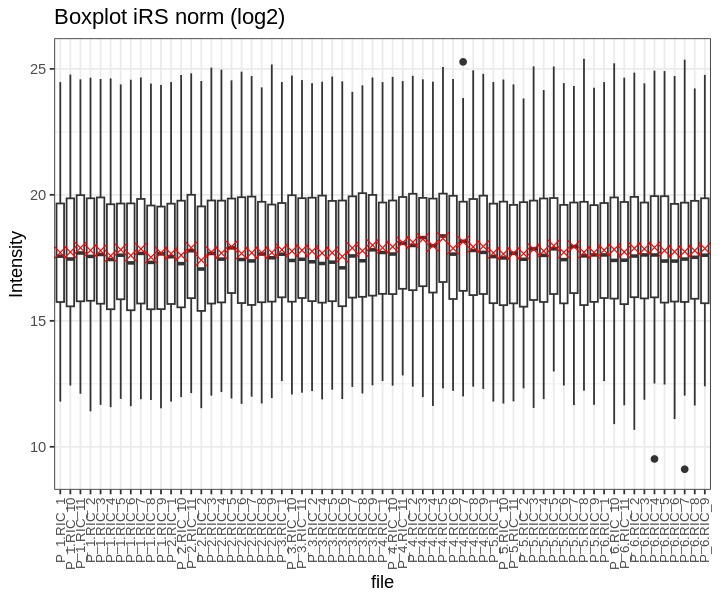

In [118]:
ref_samples <- meta_data[meta_data$Group == 'Common Reference',]$Quantitative.column.name
batch <- meta_data$Pool

# iRS on raw data
irs <- irsNorm(prot_data[, -c("Protein.IDs", "Gene.names")], meta_data, batch, ref_samples)
# add back the Protein.IDs and Gene.names
irs <- cbind(prot_data[, c("Protein.IDs", "Gene.names")], irs)

# plot PCA
pca_plot(log2(irs[, -c("Protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot iRS norm (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")
pca_irs <- pca_plot(log2(irs[, -c("Protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot iRS norm (log2)", "",
            "Quantitative.column.name", col_col = "Group", shape_col = "Pool")

# plot boxplot
boxplot_pg(log2(irs[, -c("Protein.IDs", "Gene.names")]+1), "Boxplot iRS norm (log2)", "")
boxplot_irs <- boxplot_pg(log2(irs[, -c("Protein.IDs", "Gene.names")]+1), "Boxplot iRS norm (log2)", "")


# iRS on median

Warning message:
“Removed 429 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 429 rows containing non-finite values (`stat_summary()`).”


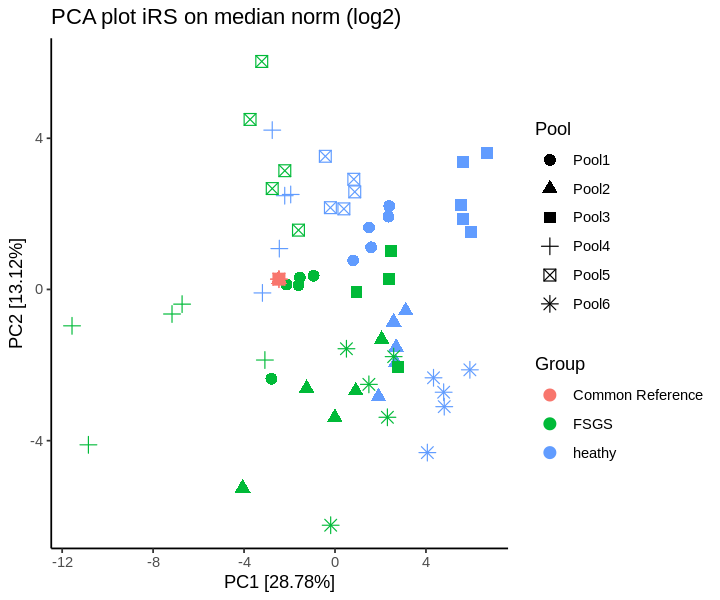

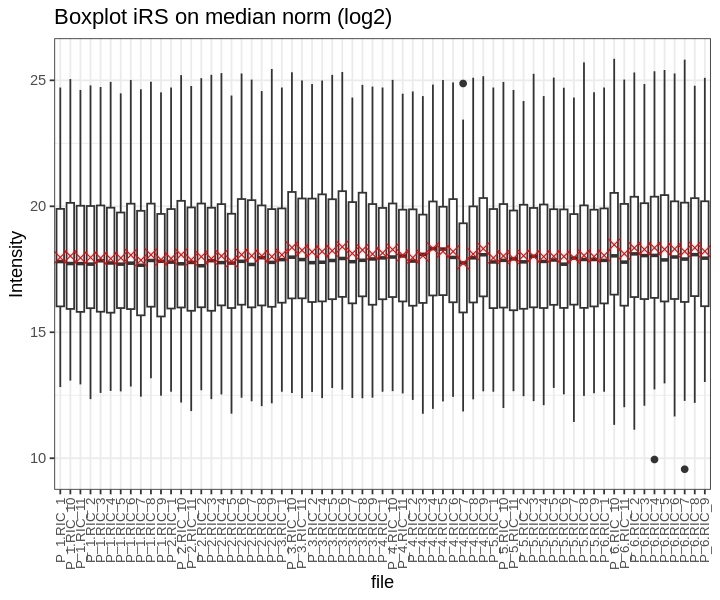

In [158]:
irs_on_median <- irsNorm(median[, -c("Protein.IDs", "Gene.names")], meta_data, batch, ref_samples)
# add back the Protein.IDs and Gene.names
irs_on_median <- cbind(median[, c("Protein.IDs", "Gene.names")], irs_on_median)

# plot PCA
pca_plot(log2(irs_on_median[, -c("Protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot iRS on median norm (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")
pca_irs_on_median <- pca_plot(log2(irs_on_median[, -c("Protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot iRS on median norm (log2)", "",
            "Quantitative.column.name", col_col = "Group", shape_col = "Pool")

# plot boxplot
boxplot_pg(log2(irs_on_median[, -c("Protein.IDs", "Gene.names")]+1), "Boxplot iRS on median norm (log2)", "")
boxplot_irs_on_median <- boxplot_pg(log2(irs_on_median[, -c("Protein.IDs", "Gene.names")]+1), "Boxplot iRS on median norm (log2)", "")


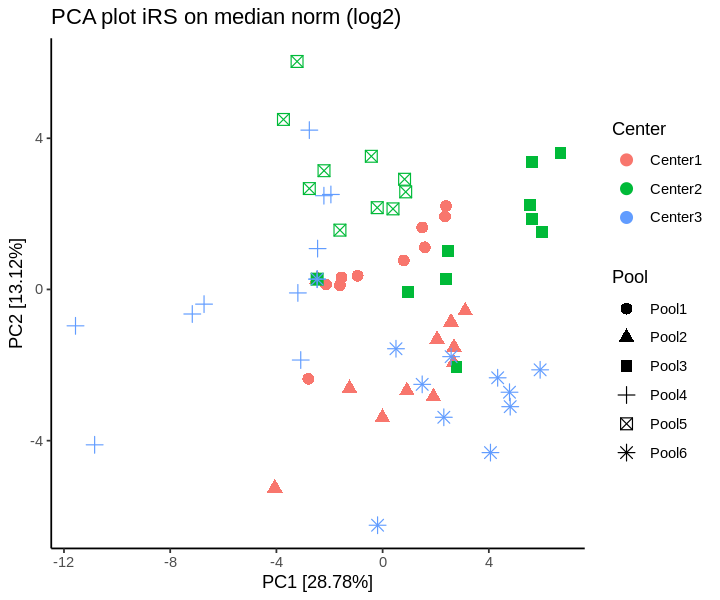

In [166]:
# plot PCA
pca_plot(log2(irs_on_median[, -c("Protein.IDs", "Gene.names")] + 1), meta_data, "PCA plot iRS on median norm (log2)", "",
         "Quantitative.column.name", col_col = "Center", shape_col = "Pool")


# Remove BE limma

In [160]:
# bacth effects correction

design <- model.matrix(~0 + meta_data$Group)
head(design)

batch <- meta_data$Pool

,meta_data$GroupCommon Reference,meta_data$GroupFSGS,meta_data$Groupheathy
1,1,0,0
2,0,0,1
3,0,1,0
4,0,0,1
5,0,1,0
6,0,0,1


## on raw data

Warning message:
“Partial NA coefficients for 25 probe(s)”
Warning message:
“Removed 425 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 425 rows containing non-finite values (`stat_summary()`).”


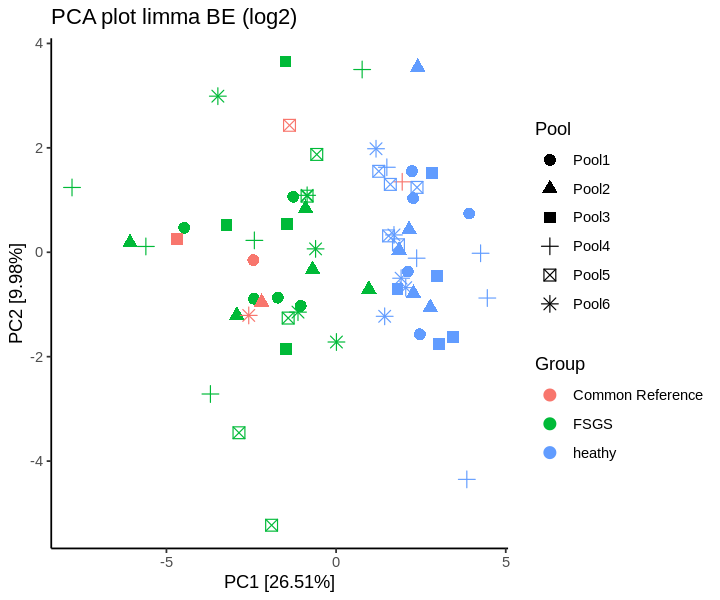

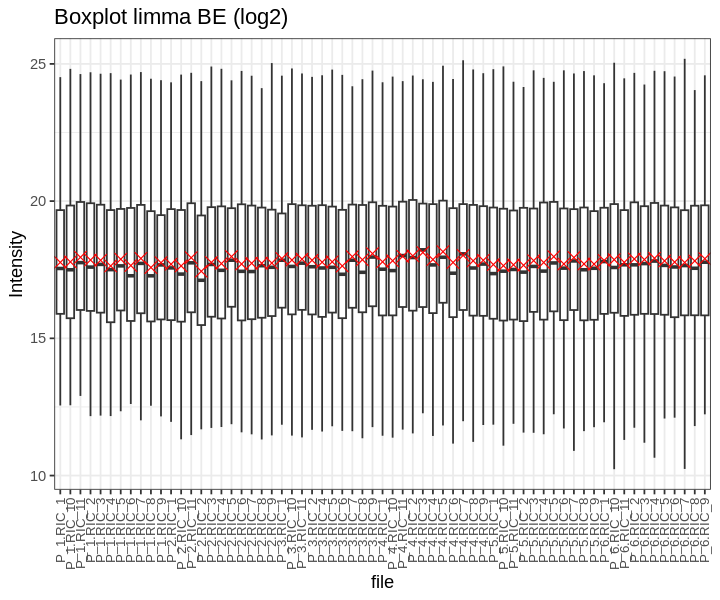

In [161]:


limBE <- limma::removeBatchEffect(log2(prot_data[, -c("Protein.IDs", "Gene.names")]), batch, design = design)
# add back the Protein.IDs and Gene.names
limBE <- cbind(prot_data[, c("Protein.IDs", "Gene.names")], limBE)


# plot PCA
pca_plot(limBE[, -c("Protein.IDs", "Gene.names")], meta_data, "PCA plot limma BE (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")

pca_limBE <- pca_plot(limBE[, -c("Protein.IDs", "Gene.names")], meta_data, "PCA plot limma BE (log2)", "",
            "Quantitative.column.name", col_col = "Group", shape_col = "Pool")

# plot boxplot
boxplot_pg(limBE[, -c("Protein.IDs", "Gene.names")], "Boxplot limma BE (log2)", "")
boxplot_limBE <- boxplot_pg(limBE[, -c("Protein.IDs", "Gene.names")], "Boxplot limma BE (log2)", "")


## on median norm data

Warning message:
“Partial NA coefficients for 25 probe(s)”
Warning message:
“Removed 425 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 425 rows containing non-finite values (`stat_summary()`).”


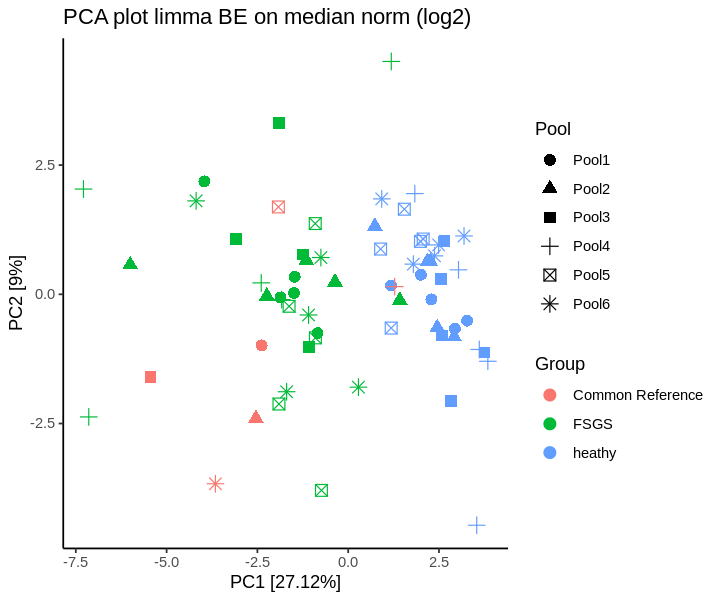

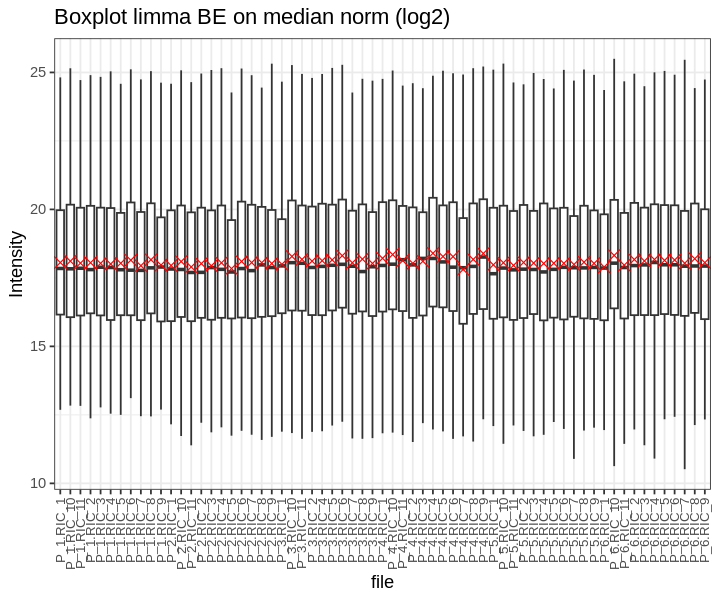

In [162]:


limBE_median <- limma::removeBatchEffect(log2(median[, -c("Protein.IDs", "Gene.names")]), batch, design = design)
# add back the Protein.IDs and Gene.names
limBE_median <- cbind(median[, c("Protein.IDs", "Gene.names")], limBE_median)

# plot PCA
pca_plot(limBE_median[, -c("Protein.IDs", "Gene.names")], meta_data, "PCA plot limma BE on median norm (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")
pca_limBE_median <- pca_plot(limBE_median[, -c("Protein.IDs", "Gene.names")], meta_data, "PCA plot limma BE on median norm (log2)", "",
            "Quantitative.column.name", col_col = "Group", shape_col = "Pool")
    

# plot boxplot
boxplot_pg(limBE_median[, -c("Protein.IDs", "Gene.names")], "Boxplot limma BE on median norm (log2)", "")
boxplot_limBE_median <- boxplot_pg(limBE_median[, -c("Protein.IDs", "Gene.names")], "Boxplot limma BE on median norm (log2)", "")

## on irs_on_median data

Warning message:
“Partial NA coefficients for 26 probe(s)”


Warning message:
“Removed 429 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 429 rows containing non-finite values (`stat_summary()`).”


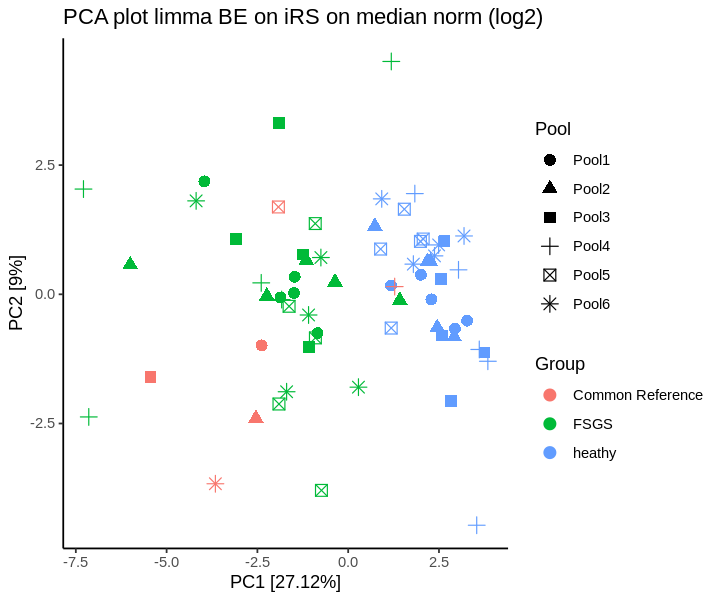

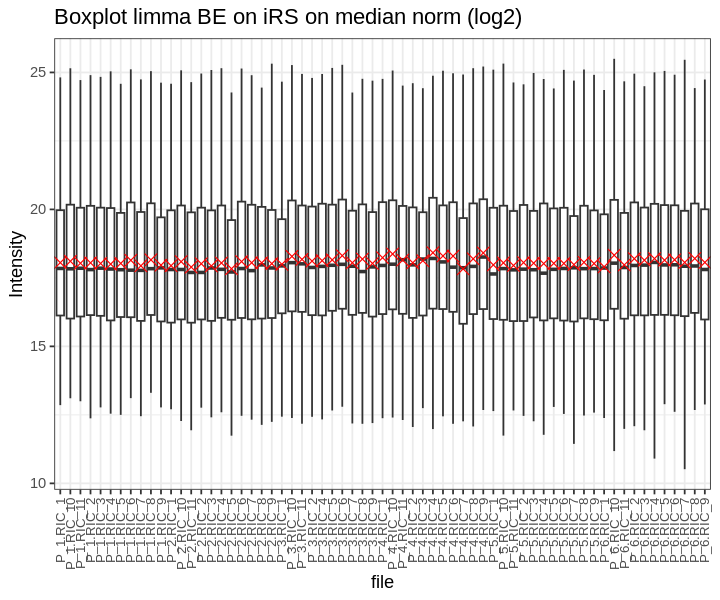

In [168]:
## on irs_on_median data
limBE_on_irs_on_median <- limma::removeBatchEffect(log2(irs_on_median[, -c("Protein.IDs", "Gene.names")]), batch, design = design)
# add back the Protein.IDs and Gene.names
limBE_on_irs_on_median <- cbind(irs_on_median[, c("Protein.IDs", "Gene.names")], limBE_on_irs_on_median)

# plot PCA
pca_plot(limBE_on_irs_on_median[, -c("Protein.IDs", "Gene.names")], meta_data, "PCA plot limma BE on iRS on median norm (log2)", "",
         "Quantitative.column.name", col_col = "Group", shape_col = "Pool")
pca_limBE_on_irs_on_median <- pca_plot(limBE_on_irs_on_median[, -c("Protein.IDs", "Gene.names")], meta_data, "PCA plot limma BE on iRS on median norm (log2)", "",
            "Quantitative.column.name", col_col = "Group", shape_col = "Pool")

# plot boxplot
boxplot_pg(limBE_on_irs_on_median[, -c("Protein.IDs", "Gene.names")], "Boxplot limma BE on iRS on median norm (log2)", "")
boxplot_limBE_on_irs_on_median <- boxplot_pg(limBE_on_irs_on_median[, -c("Protein.IDs", "Gene.names")], "Boxplot limma BE on iRS on median norm (log2)", "")